# Confronto Rendimenti attesi Fondo Pensione e PAC su ETF

Fonte dati:
- [Dati SWDA](https://www.blackrock.com/it/investitori-privati/products/251882/ishares-msci-world-ucits-etf-acc-fund)

- [Dati Seconda Pensione](https://www.secondapensione.it/product/view/QS0000003561)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parametri simulazione
anni = 36
simulazioni = 10000
versamento_annuo = 600
anno_iniziale = 2022

# Dati storici SWDA
rendimenti_swda = [23.9, -18.0, 21.9, 15.9, 27.8, -8.6, 22.4, 7.7, -0.8, 5.0]
# Dati storici Amundi Seconda Pensione Espansione
rendimenti_fp = [7.92, -8.56, 15.20, 6.76, 15.76, -8.00, 7.91, 3.25, 8.72, 9.23]

# Calcolo statistiche dai dati storici
rendimento_medio_swda = np.mean(rendimenti_swda) / 100
rendimento_medio_swda = 0.07 # ipotesi più veritiera e conservativa 
volatilita_swda = np.std(rendimenti_swda) / 100

rendimento_medio_fp = np.mean(rendimenti_fp) / 100
volatilita_fp = np.std(rendimenti_fp) / 100

print("SWDA:", rendimento_medio_swda, volatilita_swda)
print("FP:", rendimento_medio_fp, volatilita_fp)

SWDA: 0.07 0.14547632109728373
FP: 0.05819 0.0787952720662858


## Simulazione montecarlo per ritorni lordi e netti
Include la tassazione al 26% per gli ETF e la tassazione dei fondi pensione

In [15]:
def simulazione_montecarlo(rendimento_medio, volatilita, anni, simulazioni, versamento_annuo):
    risultati = []
    for _ in range(simulazioni):
        capitale = 0
        for _ in range(anni):
            rendimento = np.random.normal(rendimento_medio, volatilita)
            capitale = (capitale + versamento_annuo) * (1 + rendimento)
        risultati.append(capitale)
    return risultati

# Esecuzione simulazioni
simulazioni_swda = simulazione_montecarlo(rendimento_medio_swda, volatilita_swda, anni, simulazioni, versamento_annuo)
simulazioni_fp = simulazione_montecarlo(rendimento_medio_fp, volatilita_fp, anni, simulazioni, versamento_annuo)

# Calcolo tasse
def calcola_tasse_etf(capitali):
    tasse = []
    capitale_iniziale = versamento_annuo * anni
    for capitale in capitali:
        capital_gain = max(0, capitale - capitale_iniziale)
        tasse.append(capital_gain * 0.26)
    return tasse

def calcola_aliquota_fp(anni):
    aliquota = 0.15
    anni_oltre_15 = max(0, anni - 15)
    riduzione = min(anni_oltre_15 * 0.003, 0.06)
    return aliquota - riduzione

def calcola_tasse_fp(capitali):
    tasse = []
    capitale_iniziale = versamento_annuo * anni
    aliquota = calcola_aliquota_fp(anni)
    for capitale in capitali:
        capital_gain = max(0, capitale - capitale_iniziale)
        tasse.append(capital_gain * aliquota)
    return tasse

# Calcolo netto
imposte_etf = calcola_tasse_etf(simulazioni_swda)
imposte_fp = calcola_tasse_fp(simulazioni_fp)
netto_swda = [capitale - tassa for capitale, tassa in zip(simulazioni_swda, imposte_etf)]
netto_fp = [capitale - tassa for capitale, tassa in zip(simulazioni_fp, imposte_fp)]


print(f"Versamenti totali: {anni*versamento_annuo:,.2f}€")
print(f"SWDA - Capitale medio lordo: {np.mean(simulazioni_swda):,.2f}€")
print(f"SWDA - Capitale medio netto: {np.mean(netto_swda):,.2f}€")
print(f"Fondo Pensione - Capitale medio lordo: {np.mean(simulazioni_fp):,.2f}€")
print(f"Fondo Pensione - Capitale medio netto: {np.mean(netto_fp):,.2f}€")

Versamenti totali: 21,600.00€
SWDA - Capitale medio lordo: 96,347.99€
SWDA - Capitale medio netto: 76,901.87€
Fondo Pensione - Capitale medio lordo: 73,150.89€
Fondo Pensione - Capitale medio netto: 68,511.31€


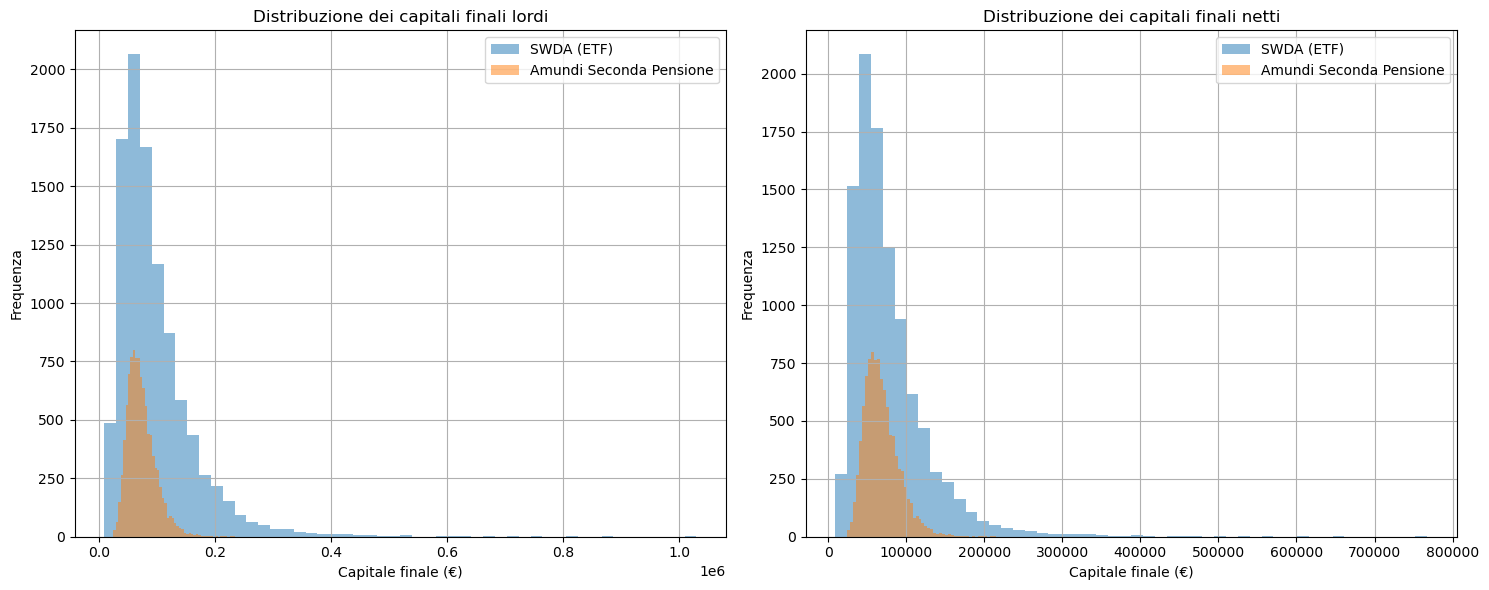

In [16]:
# Creazione subplot con due grafici affiancati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Grafico lordo
ax1.hist(simulazioni_swda, bins=50, alpha=0.5, label='SWDA (ETF)')
ax1.hist(simulazioni_fp, bins=50, alpha=0.5, label='Amundi Seconda Pensione')
ax1.legend()
ax1.set_title("Distribuzione dei capitali finali lordi")
ax1.set_xlabel("Capitale finale (€)")
ax1.set_ylabel("Frequenza")
ax1.grid(True)

# Grafico netto
ax2.hist(netto_swda, bins=50, alpha=0.5, label='SWDA (ETF)')
ax2.hist(netto_fp, bins=50, alpha=0.5, label='Amundi Seconda Pensione')
ax2.legend()
ax2.set_title("Distribuzione dei capitali finali netti")
ax2.set_xlabel("Capitale finale (€)")
ax2.set_ylabel("Frequenza")
ax2.grid(True)

plt.tight_layout()
plt.show()


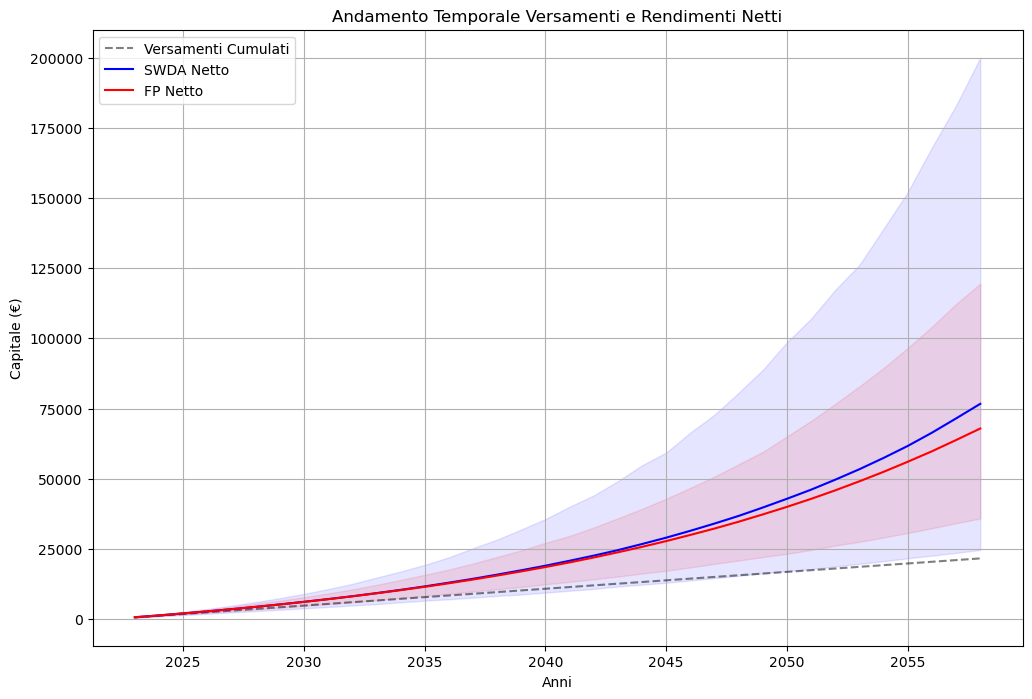

In [17]:
def simulazione_montecarlo_temporale(rendimento_medio, volatilita, anni, simulazioni, versamento_annuo):
    risultati = np.zeros((simulazioni, anni))
    versamenti = np.zeros(anni)
    
    for sim in range(simulazioni):
        capitale = 0
        for anno in range(anni):
            rendimento = np.random.normal(rendimento_medio, volatilita)
            capitale = (capitale + versamento_annuo) * (1 + rendimento)
            risultati[sim, anno] = capitale
            if sim == 0:
                versamenti[anno] = versamento_annuo * (anno + 1)
    
    media = np.mean(risultati, axis=0)
    percentile_basso = np.percentile(risultati, 2.5, axis=0)
    percentile_alto = np.percentile(risultati, 97.5, axis=0)
    
    return media, percentile_basso, percentile_alto, versamenti

# Creazione del grafico
plt.figure(figsize=(12, 8))
anni_array = np.arange(1, anni + 1) + anno_iniziale

# Calcolo serie temporali
media_swda, ci_basso_swda, ci_alto_swda, versamenti = simulazione_montecarlo_temporale(
    rendimento_medio_swda, volatilita_swda, anni, simulazioni, versamento_annuo)

media_fp, ci_basso_fp, ci_alto_fp, _ = simulazione_montecarlo_temporale(
    rendimento_medio_fp, volatilita_fp, anni, simulazioni, versamento_annuo)

# Calcolo netti temporali
def calcola_netto_temporale(capitale, versamenti, is_etf=True):
    capital_gain = np.maximum(0, capitale - versamenti)
    if is_etf:
        return capitale - (capital_gain * 0.26)
    aliquota = 0.15 - min(max(anni - 15, 0) * 0.003, 0.06)
    return capitale - (capital_gain * aliquota)

# Plot versamenti
plt.plot(anni_array, versamenti, 'k--', label='Versamenti Cumulati', alpha=0.5)

# Plot SWDA
netto_medio_swda = calcola_netto_temporale(media_swda, versamenti, True)
netto_basso_swda = calcola_netto_temporale(ci_basso_swda, versamenti, True)
netto_alto_swda = calcola_netto_temporale(ci_alto_swda, versamenti, True)

plt.plot(anni_array, netto_medio_swda, 'b-', label='SWDA Netto')
plt.fill_between(anni_array, netto_basso_swda, netto_alto_swda, color='b', alpha=0.1)

# Plot Fondo Pensione
netto_medio_fp = calcola_netto_temporale(media_fp, versamenti, False)
netto_basso_fp = calcola_netto_temporale(ci_basso_fp, versamenti, False)
netto_alto_fp = calcola_netto_temporale(ci_alto_fp, versamenti, False)

plt.plot(anni_array, netto_medio_fp, 'r-', label='FP Netto')
plt.fill_between(anni_array, netto_basso_fp, netto_alto_fp, color='r', alpha=0.1)

plt.title('Andamento Temporale Versamenti e Rendimenti Netti')
plt.xlabel('Anni')
plt.ylabel('Capitale (€)')
plt.legend()
plt.grid(True)
plt.show()


## Previsione investimenti svincolabili nel tempo

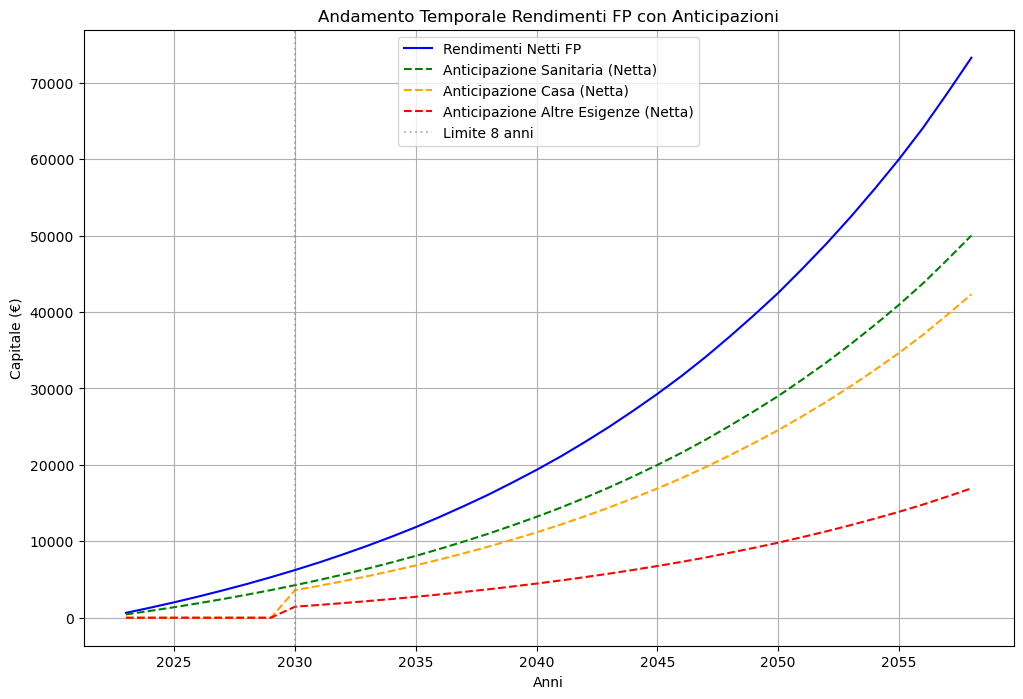

In [18]:
def simulazione_montecarlo_fp(rendimento_medio, volatilita, anni, simulazioni, versamento_annuo):
    risultati = np.zeros((simulazioni, anni))
    for sim in range(simulazioni):
        capitale = 0
        for anno in range(anni):
            rendimento = np.random.normal(rendimento_medio, volatilita)
            capitale = (capitale + versamento_annuo) * (1 + rendimento)
            risultati[sim, anno] = capitale
    return risultati

def calcola_aliquota_sanitaria(anni):
    aliquota_base = 0.15
    riduzione = min(max(anni - 15, 0) * 0.003, 0.06)
    return aliquota_base - riduzione

# Simulazione
risultati_fp = simulazione_montecarlo_fp(rendimento_medio_fp, volatilita_fp, anni, simulazioni, versamento_annuo)
media_fp = np.mean(risultati_fp, axis=0)

# Calcolo anticipazioni per ogni anno
anni_array = np.arange(1, anni + 1)
anticipazioni_sanitarie = []
anticipazioni_casa = []
anticipazioni_altre = []

for anno in range(anni):
    capitale = media_fp[anno]
    
    # Anticipazione sanitaria (sempre disponibile, 75% con aliquota ridotta)
    aliquota_sanitaria = calcola_aliquota_sanitaria(anni)
    anticipo_sanitario = capitale * 0.75 * (1 - aliquota_sanitaria)
    anticipazioni_sanitarie.append(anticipo_sanitario)
    
    # Anticipazione casa e altre (dopo 8 anni)
    if anno >= 7:  # indice 7 = anno 8
        # Casa (75% con aliquota 23%)
        anticipo_casa = capitale * 0.75 * (1 - 0.23)
        # Altre esigenze (30% con aliquota 23%)
        anticipo_altre = capitale * 0.30 * (1 - 0.23)
    else:
        anticipo_casa = 0
        anticipo_altre = 0
    
    anticipazioni_casa.append(anticipo_casa)
    anticipazioni_altre.append(anticipo_altre)

# Creazione del grafico
plt.figure(figsize=(12, 8))

plt.plot(anni_array+anno_iniziale, media_fp, 'b-', label='Rendimenti Netti FP')
plt.plot(anni_array+anno_iniziale, anticipazioni_sanitarie, 'g--', label='Anticipazione Sanitaria (Netta)')
plt.plot(anni_array+anno_iniziale, anticipazioni_casa, 'orange', linestyle='--', label='Anticipazione Casa (Netta)')
plt.plot(anni_array+anno_iniziale, anticipazioni_altre, 'r--', label='Anticipazione Altre Esigenze (Netta)')

plt.axvline(x=8+anno_iniziale, color='gray', linestyle=':', alpha=0.5, label='Limite 8 anni')
plt.title('Andamento Temporale Rendimenti FP con Anticipazioni')
plt.xlabel('Anni')
plt.ylabel('Capitale (€)')
plt.legend()
plt.grid(True)
plt.show()
